In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import os
import tensorflow as tf
from collections import Counter
import spacy
import pickle
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [23]:
nlp = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.word2idx = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
        self.idx2word = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.idx = 4

    def tokenizer(self, text):
        return [token.text.lower() for token in nlp(text)]

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        for sentence in sentence_list:
            frequencies.update(self.tokenizer(sentence))
        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx += 1

    def numericalize(self, text):
        tokenized = self.tokenizer(text)
        return [self.word2idx.get(t, self.word2idx["<unk>"]) for t in tokenized]

In [ ]:
# class Dataset:
#     def __init__(self, image_dir, caption_file, vocab, transform, max_length=30):
#         self.image_dir = image_dir
#         self.df = pd.read_csv(caption_file)
#         self.images = self.df['image'].tolist()
#         self.captions = self.df['caption'].tolist()
#         self.vocab = vocab
#         self.transform = transform
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.image_dir, self.images[idx])
#         img = Image.open(img_path).convert("RGB")
#         img = self.transform(img)
#         caption = [self.vocab.word2idx["<start>"]]
#         caption += self.vocab.numericalize(self.captions[idx])
#         caption.append(self.vocab.word2idx["<end>"])
#         caption = caption[:self.max_length]  
#         caption += [self.vocab.word2idx["<pad>"]] * (self.max_length - len(caption))
#         return img, caption[:-1], caption[1:]

In [24]:
def transform_img(img):
    img = img.resize((224, 224))
    img = np.array(img)
    img = preprocess_input(img)
    return img

Vocabulary size: 2994
  min: 3
  max: 42
  mean: 13.836361389197874
  median: 13.0
  80th: 17
  85th: 18
  90th: 19
  95th: 21
  98th: 23

Suggested max_length (covering ~90%): 19
Suggested max_length (covering ~95%): 21


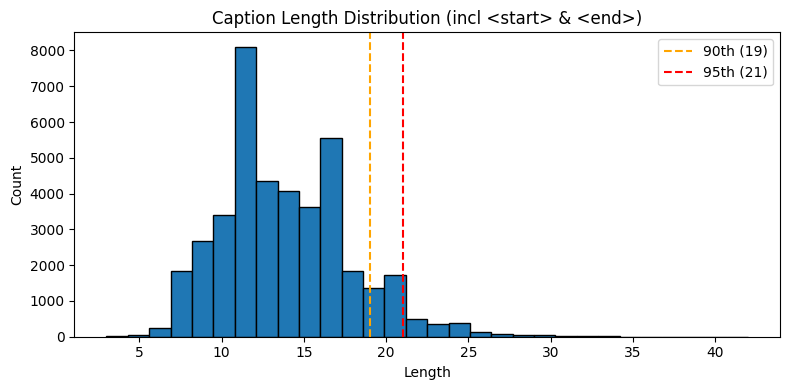

In [7]:
root_folder = "/home/devcontainers/Datasets/Images"
caption_file = "/home/devcontainers/Datasets/captions.txt"

df = pd.read_csv(caption_file)
captions = df["caption"].astype(str).tolist()
vocab = Vocabulary(freq_threshold=5)
vocab.build_vocab(captions)
print(f"Vocabulary size: {len(vocab.word2idx)}")

lengths = []
for cap in captions:
    token_ids = vocab.numericalize(cap)
    lengths.append(len(token_ids) + 2)
lengths = np.array(lengths)


summary = {
    "min": int(lengths.min()),
    "max": int(lengths.max()),
    "mean": float(np.mean(lengths)),
    "median": float(np.median(lengths)),
    "80th": int(np.percentile(lengths, 80)),
    "85th": int(np.percentile(lengths, 85)),
    "90th": int(np.percentile(lengths, 90)),
    "95th": int(np.percentile(lengths, 95)),
    "98th": int(np.percentile(lengths, 98)),
}

for k, v in summary.items():
    print(f"  {k}: {v}")
print(f"\nSuggested max_length (covering ~90%): {summary['90th']}")
print(f"Suggested max_length (covering ~95%): {summary['95th']}")

plt.figure(figsize=(8,4))
plt.hist(lengths, bins=30, edgecolor="black")
plt.axvline(summary["90th"], color="orange", linestyle="--", label=f'90th ({summary["90th"]})')
plt.axvline(summary["95th"], color="red", linestyle="--", label=f'95th ({summary["95th"]})')
plt.title("Caption Length Distribution (incl <start> & <end>)")
plt.xlabel("Length")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
MAX_LENGTH = 19
BATCH_SIZE = 4
VALIDATION_SPLIT = 0.1
SEED = 42
EMBEDDING_DIM = 128
UNITS = 256

In [26]:
input_seqs = []
target_seqs = []

for cap in captions:
    token_ids = vocab.numericalize(cap)
    caption = [vocab.word2idx["<start>"]] + token_ids + [vocab.word2idx["<end>"]]
    caption = caption[:MAX_LENGTH]  
    pad_len = MAX_LENGTH - len(caption)
    caption += [vocab.word2idx["<pad>"]] * pad_len
    caption = np.array(caption, dtype=np.int32)
    input_seqs.append(caption[:-1])   
    target_seqs.append(caption[1:])   

input_seqs = np.stack(input_seqs)   
target_seqs = np.stack(target_seqs) 
image_paths = df["image"].apply(lambda n: os.path.join(root_folder, n)).values 
train_img, val_img, train_inp, val_inp, train_tgt, val_tgt = train_test_split(
    image_paths, input_seqs, target_seqs,
    test_size=VALIDATION_SPLIT,
    random_state=SEED,
    shuffle=True
)

steps_per_epoch = math.ceil(len(train_img) / BATCH_SIZE)
validation_steps = math.ceil(len(val_img) / BATCH_SIZE)
print(f"Train samples: {len(train_img)}, Val samples: {len(val_img)}")
print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")
def preprocess(path, inp, tgt):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    return (img, inp), tgt

train_ds = (
    tf.data.Dataset.from_tensor_slices((train_img, train_inp, train_tgt))
    .map(lambda p, i, t: preprocess(p, i, t), num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((val_img, val_inp, val_tgt))
    .map(lambda p, i, t: preprocess(p, i, t), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

Train samples: 36409, Val samples: 4046
Steps per epoch: 9103, Validation steps: 1012


In [27]:
class EncoderCNN(tf.keras.Model):
    def __init__(self, embedding_dim, train_backbone=False):
        super().__init__()
        base = MobileNetV2(include_top=False, weights="imagenet", pooling="avg")
        base.trainable = train_backbone
        self.base = base
        self.fc = layers.Dense(embedding_dim)

    def call(self, x):
        x = self.base(x)
        x = self.fc(x)
        return x

In [28]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super().__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, features, hidden):
        hidden_time = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_time))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [29]:
class DecoderRNN(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units, dropout_rate=0.3):
        super().__init__()
        self.units = units
        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.attention = BahdanauAttention(units)
        self.dropout_embed = layers.Dropout(dropout_rate)
        self.lstm = layers.LSTM(units, return_sequences=True, return_state=True)
        self.dropout_lstm = layers.Dropout(dropout_rate)
        self.fc = layers.Dense(vocab_size)

    def call(self, x, features, hidden, cell, training=False):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)  
        x = self.dropout_embed(x, training=training)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)  
        output, state_h, state_c = self.lstm(x, initial_state=[hidden, cell])
        output = self.dropout_lstm(output, training=training)
        output = tf.reshape(output, (-1, output.shape[2]))  
        x = self.fc(output)  
        return x, state_h, state_c, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))


In [30]:
class ImageCaptioningModel(tf.keras.Model):
    def __init__(self, encoder, decoder, vocab, max_length):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.vocab = vocab
        self.max_length = max_length

    def call(self, inputs, training=False):
        img_tensor, captions = inputs 
        batch_size = tf.shape(captions)[0]
        hidden, cell = self.decoder.reset_state(batch_size)
        dec_input = tf.expand_dims(captions[:, 0], 1) 
        features = self.encoder(img_tensor)
        outputs = []

        for i in range(1, self.max_length):
            predictions, hidden, cell, _ = self.decoder(dec_input, features, hidden, cell, training=training)
            outputs.append(tf.expand_dims(predictions, 1)) 
            dec_input = tf.expand_dims(captions[:, i], 1) 

        return tf.concat(outputs, axis=1)

In [31]:
def custom_loss(y_true, y_pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")
    loss = loss_object(y_true, y_pred)  
    mask = tf.cast(tf.not_equal(y_true, vocab.word2idx["<pad>"]), tf.float32)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [34]:
encoder = EncoderCNN(embedding_dim=EMBEDDING_DIM, train_backbone=False)
decoder = DecoderRNN(vocab_size=len(vocab.word2idx), embedding_dim=EMBEDDING_DIM, units=UNITS, dropout_rate=0.3)
model = ImageCaptioningModel(encoder, decoder, vocab, max_length=MAX_LENGTH)

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=custom_loss)
callbacks = [
    ModelCheckpoint("attention_caption_model.keras", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1)
]

model.summary()

/tmp/ipykernel_62623/3805060730.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, weights="imagenet", pooling="avg")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "image_captioning_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_cnn_1 (EncoderCNN)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_rnn_1 (DecoderRNN)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(train_ds, epochs = 5, validation_data = val_ds, 
                    steps_per_epoch = steps_per_epoch, validation_steps = validation_steps,
                    callbacks = callbacks)